In [1]:
import pandas as pd
import pickle
import re
import numpy as np
import seaborn as sns

# Data Cleaning

In [2]:
%store -r df_nation
%store -r df_series_groups

In [3]:
df_netflix_movies = pickle.load(open('df_netflix_movies','rb'))
df_netflix_movies.reset_index(drop=True, inplace=True)

In [5]:
#Netflix Catalog before cleaning
df_netflix_movies.groupby(['original', 'titles'], as_index=False).count().groupby('original').count()

,titles,years,plots,transcripts,genres,imdb,runtime,description,stars,votes,type
original,,,,,,,,,,,
Catalog,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102
Netflix,218,218,218,218,218,218,218,218,218,218,218


### Cleaning non-English letters

In [6]:
#'ν' --> 'v'
df_netflix_movies['transcripts'] = df_netflix_movies['transcripts'].apply(lambda x:re.sub('ν', 'v', x))
# 'l'--> i e.g. lmp (imposible) -> There's a problem coming from the source of the transcripts itself
# all i in upper case are treated as l (l in lower case) Fortunately most of them are pronouns like 'I' , but some words starting with 'i' in upper case are lost (small %)

In [7]:
#raw_tokens
df_netflix_movies['raw_tokens'] = df_netflix_movies['transcripts'].apply(lambda x:len(x.split()))
print('Min Raw: ' + str(df_netflix_movies['raw_tokens'].min()))
print('Max Raw: ' + str(df_netflix_movies['raw_tokens'].max()))

Min Raw: 0
Max Raw: 23302


### Filtering transcripts out for coverage analysis

In [258]:
#first view to 'raw_tokens'
# sns.boxplot(x=df_netflix_movies['raw_tokens'])

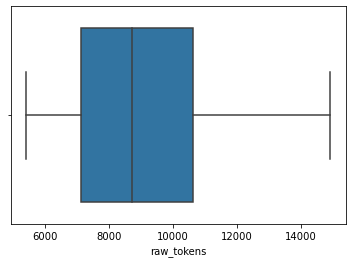

In [257]:
#Filtering out data that don't make sense
df_netflix_movies = df_netflix_movies[df_netflix_movies['raw_tokens']>=5400] #in general lower tokens means corrupter data. with this i'm excluding cartoons by accident though
df_netflix_movies = df_netflix_movies[df_netflix_movies['raw_tokens']<=15000] #around 800 transcripts out
df_netflix_movies.reset_index(drop=True, inplace=True)
#Spotting outliers
# q1, q3= np.percentile(df_netflix_movies['raw_tokens'],[25,75])
# iqr = q3 - q1
# lower_bound = q1 -(1.5 * iqr) 
# upper_bound = q3 +(1.5 * iqr) 
# print('lower_bound: '+ str(lower_bound))
# print('upper_bound: '+ str(upper_bound))

#second view to 'raw_tokens' (static boxplot)
sns.boxplot(x=df_netflix_movies['raw_tokens'])

In [13]:
# cleaning transcripts
from cleaning import clean_transcripts

round1 = lambda x: clean_transcripts(x)
df_netflix_movies['transcripts'] = df_netflix_movies['transcripts'].apply(round1)

In [14]:
df_netflix_movies = df_netflix_movies.assign(tokens=df_netflix_movies['transcripts'].apply(lambda x:len(x.split())))

In [248]:
#Netflix Catalog after cleaning
df_netflix_movies.groupby('original').count()

,titles,years,plots,transcripts,genres,imdb,runtime,description,stars,votes,type,raw_tokens,tokens
original,,,,,,,,,,,,,
Catalog,821,821,821,821,0,0,0,0,0,0,821,821,821
Netflix,176,176,176,176,176,176,176,176,176,176,176,176,176


In [19]:
#thrid view at 'tokens' (interative boxplot)
# import plotly_express as px
# import plotly.graph_objects as go
# from plotly.offline import iplot, init_notebook_mode

# fig = go.Figure()
# fig.add_box(x=df_netflix_movies['tokens'])
# iplot(fig)

## Exploratory Data Analysis

### Document-Term Matrix¶

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import scipy.sparse
cv = CountVectorizer()#only misleading words excluded for the analysis
cv_matrix = cv.fit_transform(df_netflix_movies['transcripts'])
df_dtm = pd.DataFrame.sparse.from_spmatrix(cv_matrix, index=df_netflix_movies.index,
                                           columns=cv.get_feature_names())

In [21]:
df_dtm = df_dtm.T

### Formula

In [22]:
def get_frames(indices, dtm, thousand_level=None): #, thousand_level ['4'], ['5-14']
    """1. The df_dtm gives the number of times a word (all_forms) shows up in an episode/movie
       2. Then its joined to get the level and base_forms of each word
       3. The final df has the words counted for each episode so it can be seen base_forms repetition in the final df"""
    frames = []
    for index in indices:
        df_count_words = dtm[[index]].loc[dtm[index]!=0]
        df_count_words = df_count_words.reset_index()
        df_count_words.rename(columns={"index": "all_forms", index: "count"}, inplace=True)

        df_count_words_level = pd.merge(df_count_words, df_nation[['base_forms', 'all_forms',
                                'levels_frequency', 'levels', 'levels_coverage']], how='left', on='all_forms', indicator=True)
        df_count_words_level.loc[df_count_words_level['_merge']=='left_only', 'levels_coverage'] = 100
        if thousand_level is not None: #only consider words in specific levels
            df_count_words_level = df_count_words_level[df_count_words_level['levels_frequency'].isin(thousand_level)]
        frames.append(df_count_words_level)
    df_count_words_level = pd.concat(frames)
    return df_count_words_level


def get_coverage(indices, df_dtm):
    frames = []
    for episode_index in indices:
        df_coverage_episode = get_frames([episode_index], df_dtm) ##
        df_coverage_episode = df_coverage_episode[['count' ,'levels_coverage']].groupby('levels_coverage').sum()
        df_coverage_episode.drop([28, 29], axis=0, inplace=True, errors='ignore')
        df_coverage_episode['%'] = 100 * (round(df_coverage_episode['count']/
                                            df_coverage_episode['count'].sum(), 4))
        df_coverage_episode = df_coverage_episode.reset_index()
        condition = [(df_coverage_episode['levels_coverage']<=4),
            (df_coverage_episode['levels_coverage']>=5) & (df_coverage_episode['levels_coverage']<=15),
                    (df_coverage_episode['levels_coverage']>=26)] #15 includes list from 15 to 25
        values = [df_coverage_episode['levels_coverage'], 5, df_coverage_episode['levels_coverage']]
        df_coverage_episode['lvl'] = np.select(condition, values)
        df_coverage_episode = df_coverage_episode.groupby('lvl').sum()
        df_coverage_episode['cumulative'] = df_coverage_episode['%'].cumsum()
        if len(indices)==1:   
            df_coverage_episode = df_coverage_episode[['count', '%']].T.reset_index(drop=True)
        elif len(indices)>1:
            df_coverage_episode = df_coverage_episode[['%']].T.reset_index(drop=True)
            df_coverage_episode['index'] = episode_index
        frames.append(df_coverage_episode)
    return frames

In [23]:
frames = get_coverage(df_netflix_movies.index.values, df_dtm)

### Vocabulary coverage in all episodes

In [196]:
df_statistics = pd.concat(frames, axis=0, ignore_index=True)[['index', 1, 2, 3, 4, 5, 26, 27, 100]]
#fill na values in list 27
df_statistics[27.0].fillna(0, inplace=True)
#assume you know interjections, character names and words created in the tv series
df_statistics['Lvl 1'] = df_statistics[1] + df_statistics[26] + df_statistics[27] + df_statistics[100]
df_statistics['Lvl 1+2'] = df_statistics['Lvl 1'] + df_statistics[2]
df_statistics['Lvl 1+2+3'] = df_statistics['Lvl 1+2'] + df_statistics[3]
df_statistics['Lvl 1+2+3+4'] = df_statistics['Lvl 1+2+3'] + df_statistics[4]
df_statistics = pd.concat((df_netflix_movies[['titles', 'original', 'years']], df_statistics.set_index('index')), axis=1)
df_statistics = df_statistics.round(1)

In [197]:
# #list 100 'unique words' shouldn't be greater than 5% (words  created or only used in that tv show)
df_statistics = df_statistics[df_statistics[100.0]<=3.5]
df_statistics = df_statistics.sort_values(['Lvl 1'], ascending=False)

### Filtering out 1 more transcript

In [198]:
df_statistics = df_statistics[~df_statistics['titles'].str.contains('the wolfs call')] #it's not the captions but subtitles

In [251]:
#Netflix Catalog after filtering (3.5%)
df_statistics.groupby('original').count()

,titles,years,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4
original,,,,,,,,,,,,,,
Catalog,770,770,770,770,770,770,770,770,770,770,770,770,770,770
Netflix,173,173,173,173,173,173,173,173,173,173,173,173,173,173


### Top 10 and last 10 Originals

In [254]:
#Data for Data Wrapper
#Top 10
for i in df_statistics[df_statistics['original']=='Netflix'][:10].values:
    print(i[0].title()+','+str(i[11])+','+str(i[12])+','+str(i[13]))
#Last 10
for i in df_statistics[df_statistics['original']=='Netflix'][-10:].values:
    print(i[0].title()+','+str(i[11])+','+str(i[12])+','+str(i[13]))

In The Tall Grass,95.6,97.9,98.4
A Secret Love,95.1,97.7,98.4
Under The Riccione Sun,94.6,97.2,98.0
Dangerous Lies,94.5,97.4,98.2
Bird Box,94.5,97.3,98.2
Who Would You Take To A Deserted Island,94.3,97.2,98.0
Earthquake Bird,94.3,97.2,97.8
Love Wedding Repeat,94.2,97.3,97.8
Paddleton,94.2,96.9,97.6
6 Balloons,94.2,96.8,97.1
Winter On Fire Ukraines Fight For Freedom,87.1,94.1,97.2
The Two Popes,87.1,92.3,95.8
Our Planet Behind The Scenes,87.0,92.6,94.7
Athlete A,87.0,93.2,96.6
Peewees Big Holiday,86.7,91.0,92.0
The Great Hack,86.3,92.6,97.2
A Christmas Prince The Royal Baby,86.2,92.1,95.2
Spelling The Dream,86.0,94.5,97.1
Enter The Anime,84.9,91.5,94.6
The Edge Of Democracy,82.3,90.9,96.2


### Preparing data for ScatterPlot

In [219]:
#preparing data
df_1 = df_statistics[['Lvl 1', 'titles', 'original', 'years']]
df_1 = df_1.assign(label = 'Lvl 1')
df_1.rename(columns={'Lvl 1':'lvl'}, inplace=True)
df_2 = df_statistics[['Lvl 1+2', 'titles', 'original', 'years']]
df_2 = df_2.assign(label = 'Lvl 1+2')
df_2.rename(columns={'Lvl 1+2':'lvl'}, inplace=True)
df_3 = df_statistics[['Lvl 1+2+3', 'titles', 'original', 'years']]
df_3 = df_3.assign(label = 'Lvl 1+2+3')
df_3.rename(columns={'Lvl 1+2+3':'lvl'}, inplace=True)
# df_4 = df_statistics[['Lvl 1+2+3+4', 'season_episode_names']]
# df_4 = df_4.assign(label = 'Lvl 1+2+3+4')
# df_4.rename(columns={'Lvl 1+2+3+4':'lvl'}, inplace=True)
df_dot = pd.concat([df_1, df_2, df_3])
df_dot['lvl'] = df_dot['lvl'].apply(lambda x:round(x,1))
df_dot.reset_index(drop=True, inplace=True)

In [229]:
#adding ranking column
rank = df_dot.index.values
df_dot['rank'] = rank+1
df_dot.loc[df_dot['rank']>len(df_statistics), 'rank']='-'
df_dot

,lvl,titles,original,years,label,rank
0,96.8,last night,Catalog,2010,Lvl 1,1
1,96.3,6 years,Catalog,2015,Lvl 1,2
2,96.0,blood money,Catalog,2017,Lvl 1,3
3,95.6,in the tall grass,Netflix,2019,Lvl 1,4
4,95.3,the time travelers wife,Catalog,2009,Lvl 1,5
...,...,...,...,...,...,...
2824,96.2,the edge of democracy,Netflix,2019,Lvl 1+2+3,-
2825,93.0,the first line,Catalog,2014,Lvl 1+2+3,-
2826,93.9,the wandering earth,Catalog,2019,Lvl 1+2+3,-
2827,93.0,terra,Catalog,2015,Lvl 1+2+3,-


In [230]:
#preparing data for scatterplot
title_count = []
for index, percentage in enumerate(df_dot['lvl']):
    subset = df_dot.iloc[:index+1]
    count = len(subset[subset['lvl']==percentage])
    title_count.append(count)

df_dot['count'] = title_count

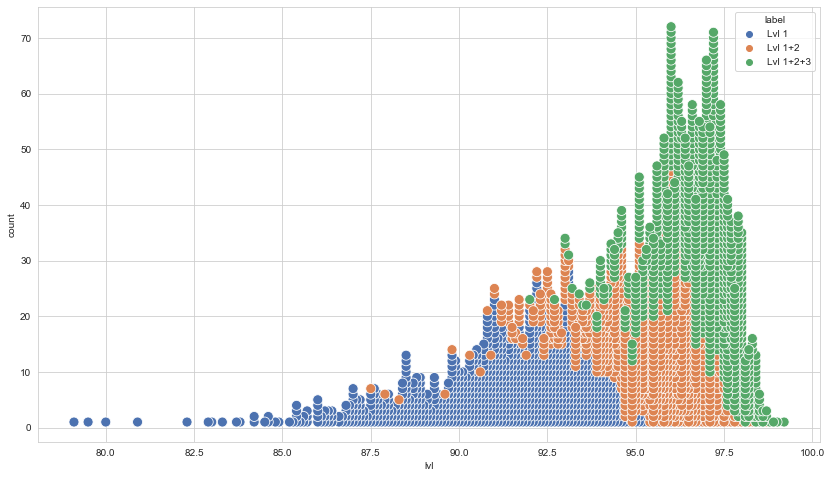

In [265]:
#static scatterplot seaborn
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='lvl', y='count', data=df_dot,
             hue='label', s=100, ax=ax, palette="deep")

# data for ScatterPlot in DataWrapper
# for i in df_dot.values:
#     print(i[1].title() + ', ' + str(i[3]) + ', ' + str(i[0]) + ', ' + str(i[4]) + ', ' + str(i[2])+', '+ str(i[5])+', '+ str(i[6]))

### Top 10 Netflix Originals

In [244]:
for i in df_statistics[df_statistics['original']=='Netflix'][:10].values:
    print(i[0].title()+' ('+str(i[2])+')')

In The Tall Grass (2019)
A Secret Love (2020)
Under The Riccione Sun (2020)
Dangerous Lies (2020)
Bird Box (2018)
Who Would You Take To A Deserted Island (2019)
Earthquake Bird (2019)
Love Wedding Repeat (2020)
Paddleton (2019)
6 Balloons (2018)


In [ ]:
#Comparing levels
# list_1 = df_statistics.sort_values(1.0, ascending=False)[:100].index.values
# list_2 = df_statistics.sort_values('Lvl 1', ascending=False)[:100].index.values
# i = [i for i in list_1 if i in list_2]
# len(i)